In [1]:
import json
import os
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from itertools import cycle

sns.set_theme(style='white', palette=None)
color_pal = plt.rcParams['axes.prop_cycle'].by_key()['color']
color_cycle = cycle(plt.rcParams['axes.prop_cycle'].by_key()['color'])

In [2]:
def load_df(file_path):
    # Load the CSV dataset
    if file_path.endswith('.xlsx'):
        df = pd.read_excel(file_path)
    else:
        df = pd.read_csv(file_path)
    return df

In [3]:
excel_file_path = "../datasets/Greek_Music_Dataset.xlsx"
train_songs_path = "creating_spectrogram_batches/train_songs.json"
test_songs_path = "creating_spectrogram_batches/test_songs.json"

In [4]:
with open(train_songs_path, 'r') as train_data:
    train_songs = json.loads(train_data.read())
    train_songs = list(train_songs.keys())
    train_data.close()

with open(test_songs_path, 'r') as test_data:
    test_songs = json.loads(test_data.read())
    test_songs = list(test_songs.keys())
    test_data.close()

available_songs = train_songs + test_songs

In [5]:
len(available_songs)

1033

In [6]:
df = load_df(excel_file_path)

In [7]:
df = df[df['Song'].isin(available_songs)].drop_duplicates(subset=['Song'])

In [8]:
df.info

<bound method DataFrame.info of                    Artist                               Song  \
0          Magic de spell                       Pes Oti Thes   
1                  Trypes                     Xartino tsirko   
3                  Trypes  Patrida mou einai ekei pou mishsa   
4                  Trypes                    Tsakismenh xara   
5                     Hrw                             Tipota   
...                   ...                                ...   
1393       Tonhs Maroudas            Menw se kapoia geitonia   
1395  Dhmhtrhs Mitropanos                         Louna Park   
1396  Stelios Kazantzidhs             Nyxterides kai araxnes   
1397       Giwrgos Sarrhs  Me ta fwta nystagmena oi ntalikes   
1398  Antwnhs Kalogiannhs              Ax Annoula tou xionia   

                                    YouTube Link MIDI VALENCE(A-D)  \
0     http://www.youtube.com/watch?v=Uu1jAlnijVI   No            A   
1     http://www.youtube.com/watch?v=eXuxMWbYEro   No      

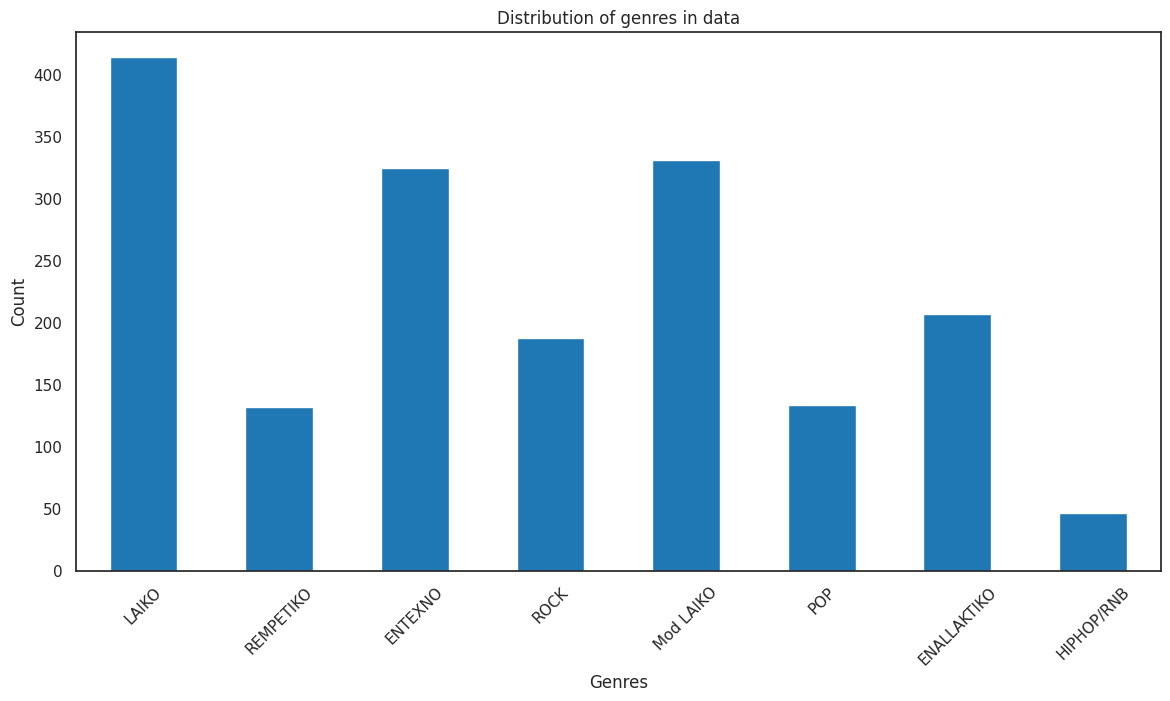

In [9]:
yes_counts_total = (df.iloc[:, 6:14] == 'Yes').sum()

plt.figure(figsize=(14, 7))
yes_counts_total.plot(kind='bar')
plt.xlabel("Genres")
plt.ylabel("Count")
plt.title("Distribution of genres in data")
plt.xticks(rotation=45)
plt.show();

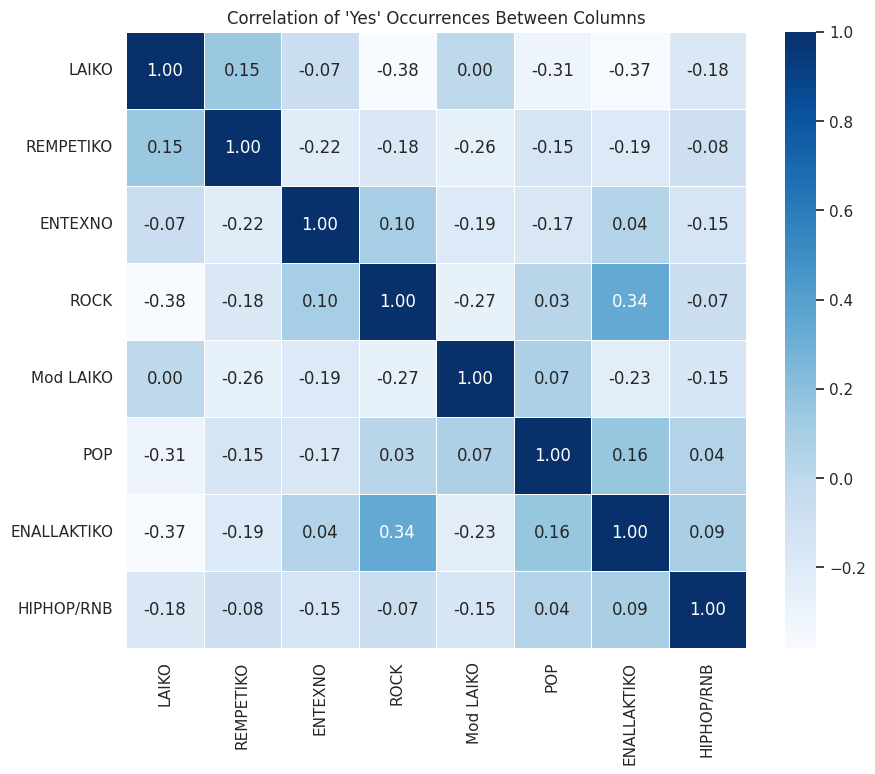

In [10]:
# Convert "Yes"/"No" to binary (1 for Yes, 0 for No)
binary_df = (df.iloc[:, 6:14] == "Yes").astype(int)

# Compute correlation between columns
corr_matrix = binary_df.corr()

# Plot heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap="Blues", fmt=".2f", linewidths=0.5)
plt.title("Correlation of 'Yes' Occurrences Between Columns")
plt.show()

In [11]:
import tensorflow as tf

2025-03-23 01:53:50.728898: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-03-23 01:53:50.738958: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1742694830.750383    4581 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1742694830.753931    4581 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-03-23 01:53:50.768580: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instr

In [12]:
directory_train = 'creating_spectrogram_batches/tfrecord_dataset/train/'
directory_train = os.fsencode(directory_train)

In [13]:
def parse_function(record):
    features = {
        'mel_spectrogram': tf.io.FixedLenFeature([], tf.string),
        'labels': tf.io.VarLenFeature(tf.int64),
        'song_name': tf.io.FixedLenFeature([], tf.string),
        'segment_idx': tf.io.FixedLenFeature([], tf.int64),
        'total_segments': tf.io.FixedLenFeature([], tf.int64)
    }
    example = tf.io.parse_single_example(record, features)
    return example['song_name'], example['labels']

In [14]:
import glob
print(len(glob.glob("creating_spectrogram_batches/tfrecord_dataset/train/*.tfrecord")))

50


In [15]:
songs_with_labels_train = {}
for record in os.listdir(directory_train):
    dataset_train = tf.data.TFRecordDataset(directory_train + record)
    dataset_train = dataset_train.map(parse_function)
    for data in dataset_train:
        song_name = data[0].numpy().decode('utf-8')
        if not song_name.endswith('_aug'):
            songs_with_labels_train[song_name] = tf.sparse.to_dense(data[1]).numpy()

print("Unique song names:", len(songs_with_labels_train))

I0000 00:00:1742694834.586987    4581 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 5520 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 4070 Laptop GPU, pci bus id: 0000:01:00.0, compute capability: 8.9
2025-03-23 01:53:54.770639: I tensorflow/core/kernels/data/tf_record_dataset_op.cc:370] TFRecordDataset `buffer_size` is unspecified, default to 262144
2025-03-23 01:53:56.515260: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2025-03-23 01:53:58.379343: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2025-03-23 01:54:02.439535: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2025-03-23 01:54:09.382920: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of

Unique song names: 873


In [16]:
prev = None
total = 0

for data in dataset_train.take(1000):

    song_name = data[0].numpy().decode('utf-8')
    if song_name != prev:
        if total == 0:
            print(song_name,'\n', tf.sparse.to_dense(data[1]).numpy())
        prev = song_name
        total += 1
total

Esena den sou aksize agaph_aug 
 [1 1 0 0 0 0 0 0]


13

In [17]:
label_vectors_train = list(map(np.array, songs_with_labels_train.values()) )

In [18]:
genre_order = ['LAIKO', 'REMPETIKO', 'ENTEXNO', 'ROCK', 'Mod LAIKO', 'POP', 'ENALLAKTIKO', 'HIPHOP/RNB']

In [19]:
df_train_distr = pd.DataFrame(label_vectors_train, columns=genre_order)

In [20]:
df_train_distr.head()

,LAIKO,REMPETIKO,ENTEXNO,ROCK,Mod LAIKO,POP,ENALLAKTIKO,HIPHOP/RNB
0,0,0,0,1,0,0,0,0
1,0,0,0,1,0,0,1,0
2,0,0,0,0,0,1,1,0
3,0,0,1,1,0,0,0,0
4,0,0,1,1,1,0,1,0


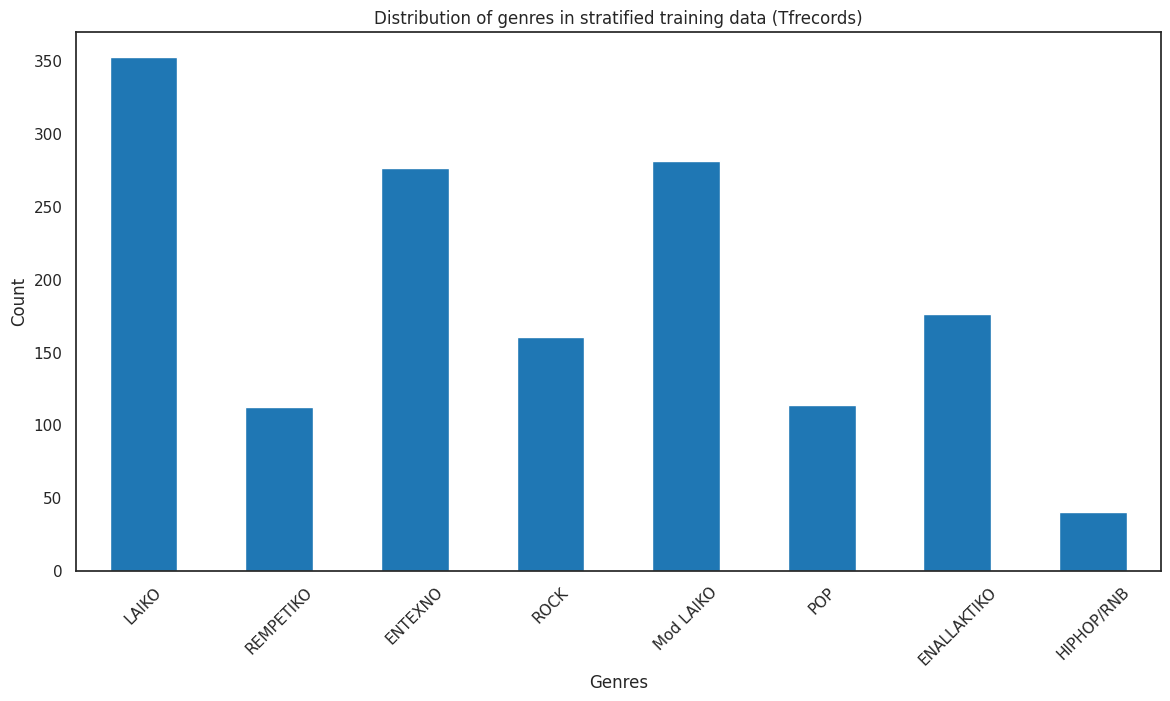

In [21]:
yes_counts_train = (df_train_distr.iloc[:, :] == 1).sum()

plt.figure(figsize=(14, 7))
yes_counts_train.plot(kind='bar')
plt.xlabel("Genres")
plt.ylabel("Count")
plt.title("Distribution of genres in stratified training data (Tfrecords)")
plt.xticks(rotation=45)
plt.show();

In [22]:
directory_test = 'creating_spectrogram_batches/tfrecord_dataset/test/'
directory_test = os.fsencode(directory_test)

In [23]:
print(len(glob.glob("creating_spectrogram_batches/tfrecord_dataset/test/*.tfrecord")))
songs_with_labels_test = {}
for record in os.listdir(directory_test):
    dataset_test = tf.data.TFRecordDataset(directory_test + record)
    dataset_test = dataset_test.map(parse_function)
    for data in dataset_test:
        song_name = data[0].numpy().decode('utf-8')
        if not song_name.endswith('_aug'):
            songs_with_labels_test[song_name] = tf.sparse.to_dense(data[1]).numpy()

print("Unique song names:", len(songs_with_labels_test))

5
Unique song names: 160


In [24]:
prev = None
total = 0
for data in dataset_test.take(1000):

    song_name = data[0].numpy().decode('utf-8')
    if song_name != prev:
        if total == 0:
            print(song_name,'\n', tf.sparse.to_dense(data[1]).numpy())
 
        prev = song_name
        total += 1
total

Egklhma ekanes 
 [1 0 0 0 1 0 0 0]


20

In [25]:
label_vectors_test = list(map(np.array, songs_with_labels_test.values()) )

In [26]:
df_test_distr = pd.DataFrame(label_vectors_test, columns=genre_order)

In [27]:
df_test_distr.head()

,LAIKO,REMPETIKO,ENTEXNO,ROCK,Mod LAIKO,POP,ENALLAKTIKO,HIPHOP/RNB
0,0,0,0,1,0,0,1,0
1,0,0,0,1,0,0,0,0
2,0,0,1,0,0,0,0,0
3,0,0,1,1,0,0,0,0
4,0,0,1,1,0,0,0,0


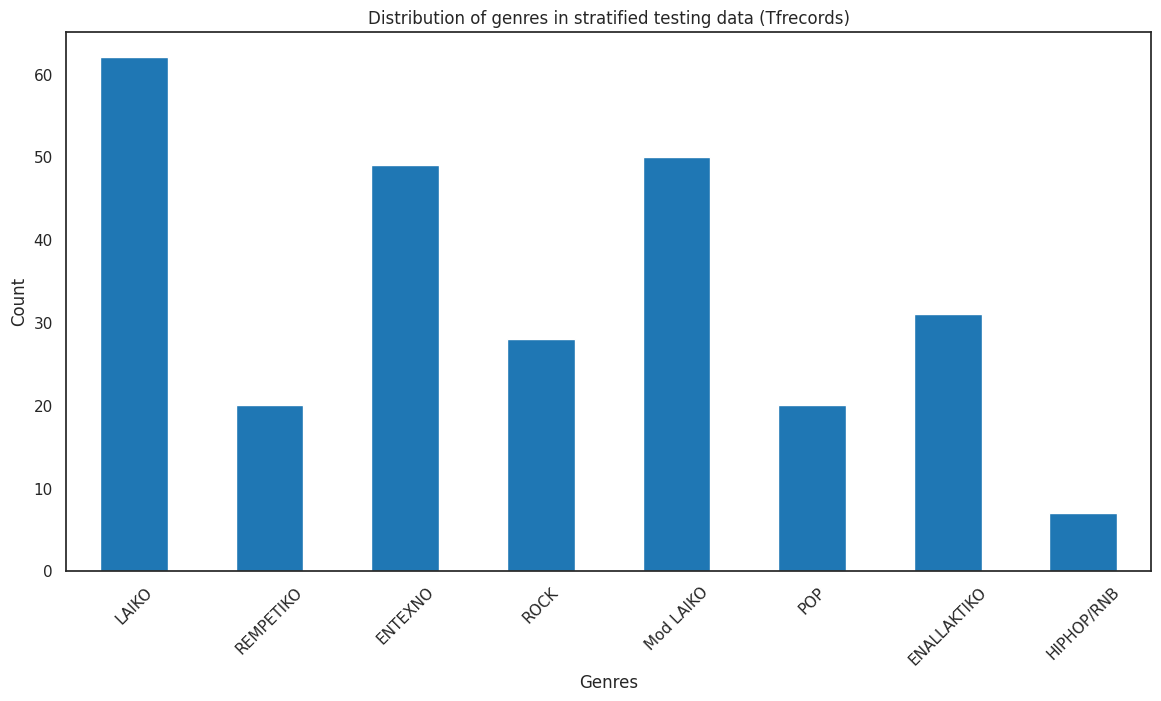

In [28]:
yes_counts_test = (df_test_distr.iloc[:, :] == 1).sum()

plt.figure(figsize=(14, 7))
yes_counts_test.plot(kind='bar')
plt.xlabel("Genres")
plt.ylabel("Count")
plt.title("Distribution of genres in stratified testing data (Tfrecords)")
plt.xticks(rotation=45)
plt.show();

In [29]:
print(yes_counts_total)
print(yes_counts_train)
print(yes_counts_test)

LAIKO          414
REMPETIKO      132
ENTEXNO        325
ROCK           188
Mod LAIKO      331
POP            134
ENALLAKTIKO    207
HIPHOP/RNB      47
dtype: int64
LAIKO          352
REMPETIKO      112
ENTEXNO        276
ROCK           160
Mod LAIKO      281
POP            114
ENALLAKTIKO    176
HIPHOP/RNB      40
dtype: int64
LAIKO          62
REMPETIKO      20
ENTEXNO        49
ROCK           28
Mod LAIKO      50
POP            20
ENALLAKTIKO    31
HIPHOP/RNB      7
dtype: int64


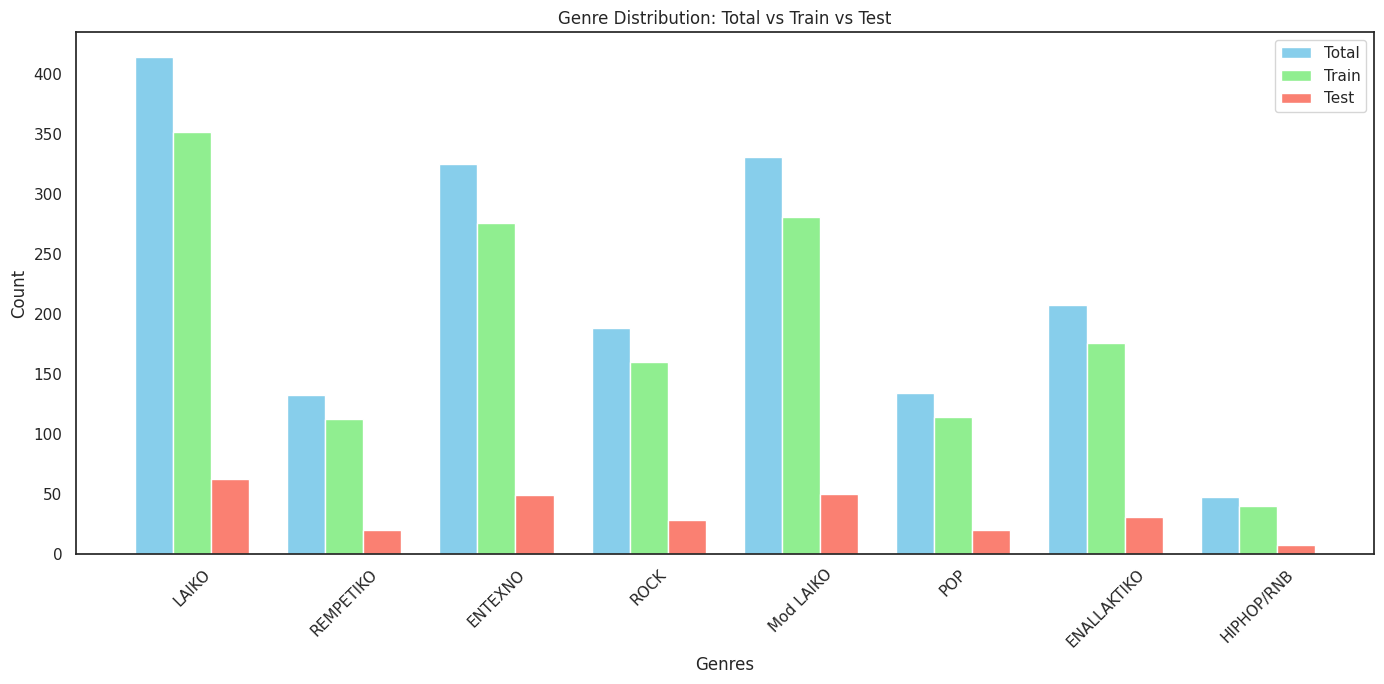

In [30]:
splits = {
    "Total": yes_counts_total,
    "Train": yes_counts_train,
    "Test": yes_counts_test
}

labels = yes_counts_total.index
x = np.arange(len(labels))  # bar positions

width = 0.25  # width of each bar

fig, ax = plt.subplots(figsize=(14, 7))

# Plot each split with offset
colors = ['skyblue', 'lightgreen', 'salmon']
for i, (name, counts) in enumerate(splits.items()):
    ax.bar(x + i * width, counts.values, width=width, label=name, color=colors[i])

# Formatting
ax.set_xlabel("Genres")
ax.set_ylabel("Count")
ax.set_title("Genre Distribution: Total vs Train vs Test")
ax.set_xticks(x + width)  # center tick labels
ax.set_xticklabels(labels, rotation=45)
ax.legend()
plt.tight_layout()
plt.show();

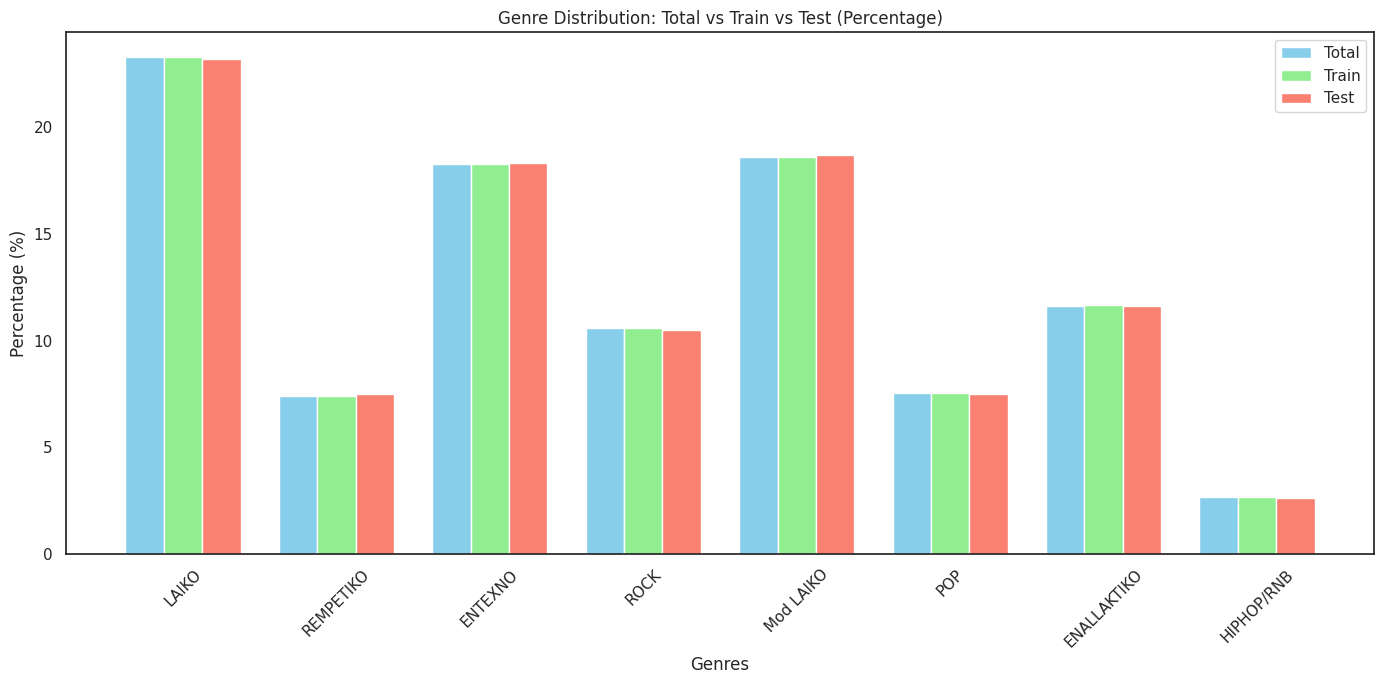

In [39]:
# Calculate percentages for each split
splits_percent = {}
for name, counts in splits.items():
    total = counts.sum()  # Sum of all genre counts in this split
    splits_percent[name] = (counts / total * 100)  # Convert to percentage

labels = yes_counts_total.index
x = np.arange(len(labels))  # bar positions

width = 0.25

fig, ax = plt.subplots(figsize=(14, 7))

# Plot each split with offset using percentages
colors = ['skyblue', 'lightgreen', 'salmon']
for i, (name, counts) in enumerate(splits_percent.items()):
    ax.bar(x + i * width, counts.values, width=width, label=name, color=colors[i])

# Formatting
ax.set_xlabel("Genres")
ax.set_ylabel("Percentage (%)")
ax.set_title("Genre Distribution: Total vs Train vs Test (Percentage)")
ax.set_xticks(x + width)  # center tick labels
ax.set_xticklabels(labels, rotation=45)
ax.legend()
plt.tight_layout()
plt.show()

In [40]:
# representative distribution

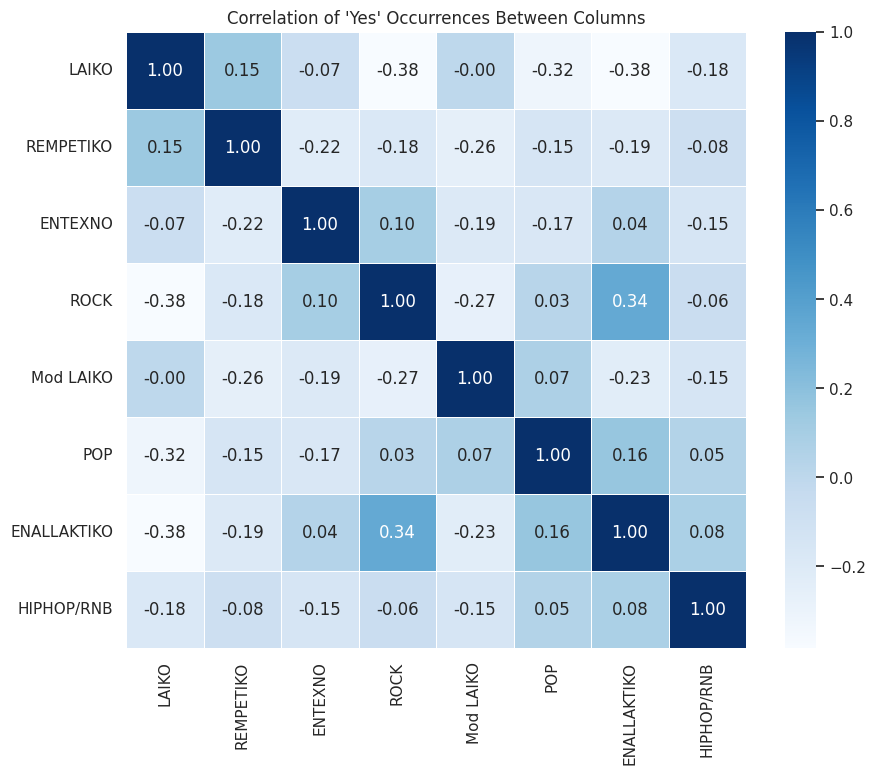

In [31]:
corr_matrix = df_train_distr.corr()

# Plot heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap="Blues", fmt=".2f", linewidths=0.5)
plt.title("Correlation of 'Yes' Occurrences Between Columns")
plt.show();

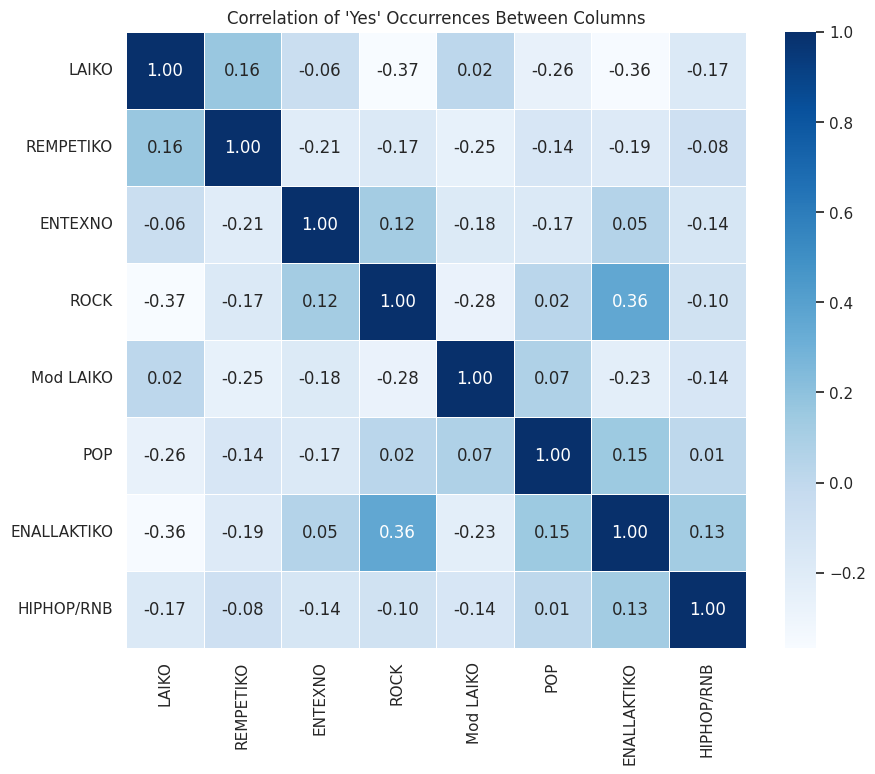

In [32]:
corr_matrix = df_test_distr.corr()

# Plot heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap="Blues", fmt=".2f", linewidths=0.5)
plt.title("Correlation of 'Yes' Occurrences Between Columns")
plt.show();

In [33]:
#The data quality is looking good, representative distributions are remained
#now let's look if there is label alignment between the labels in the tfrecords and the dataset.

In [34]:
df[:1]

,Artist,Song,YouTube Link,MIDI,VALENCE(A-D),AROUSAL(1-4),LAIKO,REMPETIKO,ENTEXNO,ROCK,Mod LAIKO,POP,ENALLAKTIKO,HIPHOP/RNB,LAST.FM IDs
0,Magic de spell,Pes Oti Thes,http://www.youtube.com/watch?v=Uu1jAlnijVI,No,A,3,No,No,No,Yes,No,No,No,No,NaN


In [42]:
print(list(songs_with_labels_train.keys())[0], list(songs_with_labels_train.values())[0] )

Pes Oti Thes [0 0 0 1 0 0 0 0]


In [44]:
misaligned_songs = []

for song_name, label_vector in songs_with_labels_train.items():
    # Skip augmented versions
    if len(song_name) > 3 and song_name[-4] == '_':
        continue

    # Convert multi-hot vector to genre list
    label_genres = sorted([genre_order[i] for i, val in enumerate(label_vector) if val == 1])

    # Get matching row from the dataframe
    row = df[df['Song'].str.lower() == song_name.lower()]
    if row.empty:
        print(f"Song {song_name} not found in dataset")
        misaligned_songs.append(song_name)
        continue

    # Extract genres from dataframe row
    df_genres = sorted([
        genre for genre in genre_order
        if pd.notna(row[genre].iloc[0]) and (
            row[genre].iloc[0] in [1, True, 'Yes', 'true', 'yes']
        )
    ])

    # Compare
    if label_genres != df_genres:
        print(f"Misalignment: {song_name}")
        print(f"  From labels:  {', '.join(label_genres)}")
        print(f"  From dataset: {', '.join(df_genres)}\n")
        misaligned_songs.append(song_name)

print(f"\nTotal misaligned songs in train split: {len(misaligned_songs)}")


Total misaligned songs in train split: 0


In [45]:
misaligned_songs = []

for song_name, label_vector in songs_with_labels_test.items():
    # Skip augmented versions
    if len(song_name) > 3 and song_name[-4] == '_':
        continue

    # Convert multi-hot vector to genre list
    label_genres = sorted([genre_order[i] for i, val in enumerate(label_vector) if val == 1])

    # Get matching row from the dataframe
    row = df[df['Song'].str.lower() == song_name.lower()]
    if row.empty:
        print(f"Song {song_name} not found in dataset")
        misaligned_songs.append(song_name)
        continue

    # Extract genres from dataframe row
    df_genres = sorted([
        genre for genre in genre_order
        if pd.notna(row[genre].iloc[0]) and (
            row[genre].iloc[0] in [1, True, 'Yes', 'true', 'yes']
        )
    ])

    # Compare
    if label_genres != df_genres:
        print(f"Misalignment: {song_name}")
        print(f"  From labels:  {', '.join(label_genres)}")
        print(f"  From dataset: {', '.join(df_genres)}\n")
        misaligned_songs.append(song_name)

print(f"\nTotal misaligned songs in test split: {len(misaligned_songs)}")


Total misaligned songs in test split: 0


In [46]:
#No misalignments found between labels